In [28]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import mobilenet_v2

# load CNN model MobileNetV2
model = mobilenet_v2(pretrained=True)
model.eval()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [29]:
# Define the transformation for image normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [30]:
def get_embedding(image):
    """
    Gets the embedding from the image.

    Args:
        image (PIL Image): image.

    Returns:
        torch.Tensor: embedding.
    """
    
    image = image.convert('RGB')
    
    # transform image to tensor
    image = transform(image)

    # Add a measurement for batch
    image = image.unsqueeze(0)

    # forward
    with torch.no_grad():
        embedding = model(image)

    # Extract the embedding from the last layer
    embedding = embedding[-1]

    return embedding


In [31]:
def image_read(data_path):
    '''
    This function reads .jpg .png images from a directory in NumPy array format.

    Args:
        data_path (str): The path to the directory with the images.

    Returns:
        list: images images array.
    '''
    
    images = []
    with tqdm.tqdm(total=len(os.listdir(data_path))) as pbar:
        for image_path in os.listdir(data_path):
            if image_path.endswith(".jpg") or image_path.endswith(".png"):
                image = cv2.imread(os.path.join(data_path, image_path))

                # resize image and add to array
                images.append(cv2.resize(image, (100, 100)))
                
                pbar.update(1)

    return images

In [32]:
import os
import cv2
import tqdm
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn import metrics

In [33]:
# path to folder with images
data_path = './cropped_defects'

images = np.array(image_read(data_path))
embeddings = []

# Embedding loop for each image
with tqdm.tqdm(total=len(images)) as pbar:
    for image in images:

        embedding = get_embedding(Image.fromarray(np.uint8(image)))
        embeddings.append(embedding.detach().numpy())
        
        pbar.update(1)

100%|██████████| 8415/8415 [01:24<00:00, 99.57it/s] 


In [34]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering as HierarchicalClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

embeddings = np.array(embeddings)

# Embedding normalization
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

embeddings.shape

(8415, 1000)

In [35]:
from sklearn.cluster import MiniBatchKMeans

In [45]:
# determine the range of the number of clusters
num_clusters_range = range(2, 11)

# initialize the list for storing silhouette values
silhouette_scores = []

# finding the optimal number of clusters
with tqdm.tqdm(total=len(num_clusters_range), desc="Finding the optimal number of clusters: ") as pbar:
    for num_clusters in num_clusters_range:
        
        # initialize the `MiniBatchKMeans`
        kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=128)
        
        kmeans.fit(embeddings)

        cluster_labels = kmeans.labels_

        # calculate silhouette score
        silhouette_score = metrics.silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_score)

        pbar.update(1)

# determine the optimal number of clusters
optimal_num_clusters = num_clusters_range[silhouette_scores.index(max(silhouette_scores))]

print(f'Optimal number of clusters: {optimal_num_clusters}')


Finding the optimal number of clusters:   0%|          | 0/9 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
Finding the optimal number of clusters:  11%|█         | 1/9 [00:01<00:14,  1.86s/it]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
Finding the optimal number of clusters:  22%|██▏       | 2/9 [00:03<00:12,  1.76s/it]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change fr

Optimal number of clusters: 2


In [46]:
# calculate the silhouette score
silhouette_avg = metrics.silhouette_score(embeddings, cluster_labels)
print('average silhouette score:', silhouette_avg)

# calculate the Calinski-Harabasz score
calinski_harabasz_score_avg = metrics.calinski_harabasz_score(embeddings, cluster_labels)
print('avarage Calinski-Harabasz score:', calinski_harabasz_score_avg)

average silhouette score: 0.07613099
avarage Calinski-Harabasz score: 619.3543859509518


In [47]:
silhouette_scores

[0.14050657,
 0.13449696,
 0.11282072,
 0.10720603,
 0.12884578,
 0.068997495,
 0.08160431,
 0.06956264,
 0.07613099]

In [48]:
import matplotlib.pyplot as plt

100%|█████████▉| 8415/8416 [00:01<00:00, 8005.59it/s]


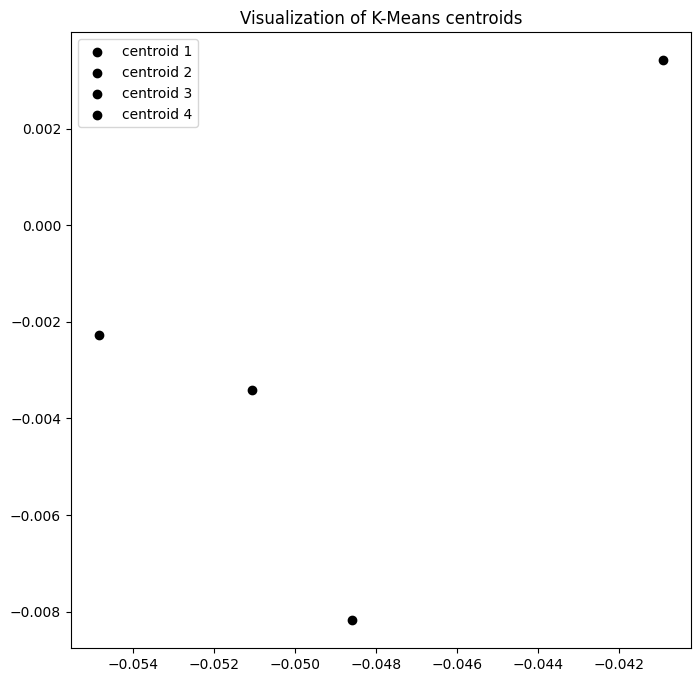

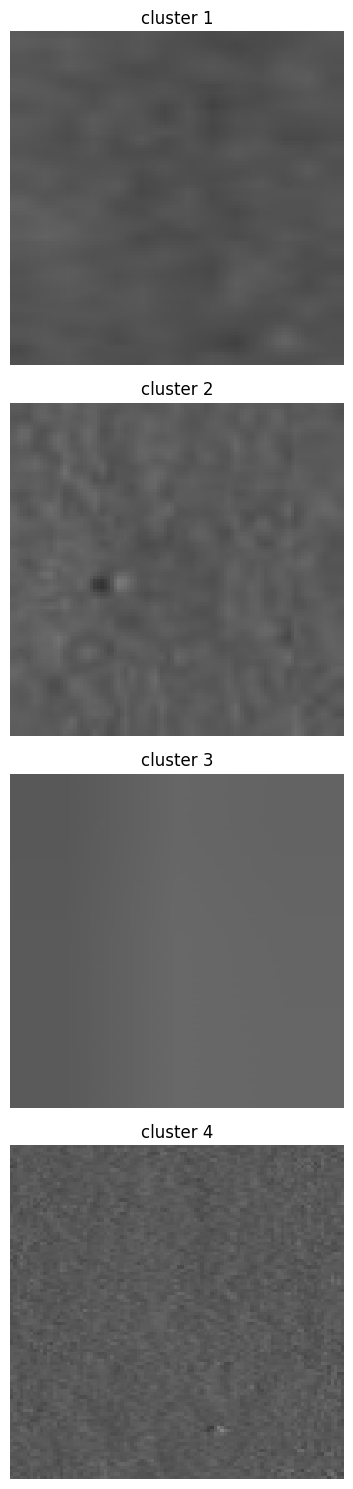

In [49]:
data_path = './cropped_defects'

images = np.array(image_read(data_path))

# Visualize the centroids of the clusters
centroids = kmeans.cluster_centers_
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(4):
    ax.scatter(centroids[i][0], centroids[i][1], c='black', label='centroid '+str(i+1))
ax.legend()
plt.title('Visualization of K-Means centroids')
plt.show()

# Visualize image distribution
fig, axes = plt.subplots(4, 1, figsize=(15, 15))
for i in range(4):
    axes[i].imshow(images[cluster_labels == i][0], cmap='gray')
    axes[i].set_title('cluster '+str(i+1))
    axes[i].axis('off')
plt.tight_layout()
plt.show()

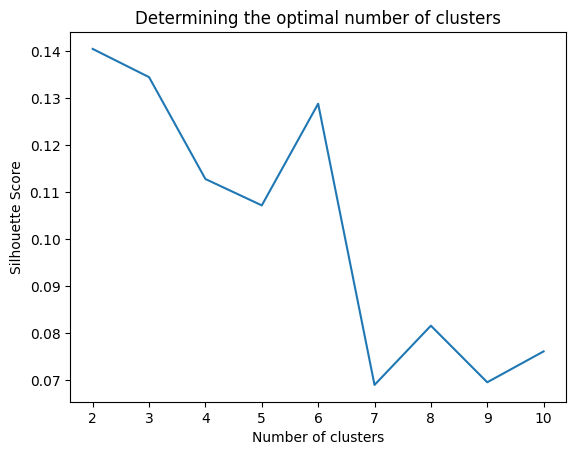

In [50]:
plt.plot(num_clusters_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Determining the optimal number of clusters')
plt.show()

## кластеризация на 3 кластера с помощью k-means

In [51]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(embeddings)

cluster_labels = kmeans.labels_

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [52]:
# calculate the silhouette score
silhouette_avg = metrics.silhouette_score(embeddings, cluster_labels)
print('average silhouette score:', silhouette_avg)

# calculate the Calinski-Harabasz score
calinski_harabasz_score_avg = metrics.calinski_harabasz_score(embeddings, cluster_labels)
print('avarage Calinski-Harabasz score:', calinski_harabasz_score_avg)

average silhouette score: 0.13205428
avarage Calinski-Harabasz score: 1186.9336221684107


100%|█████████▉| 8415/8416 [00:01<00:00, 8279.87it/s]


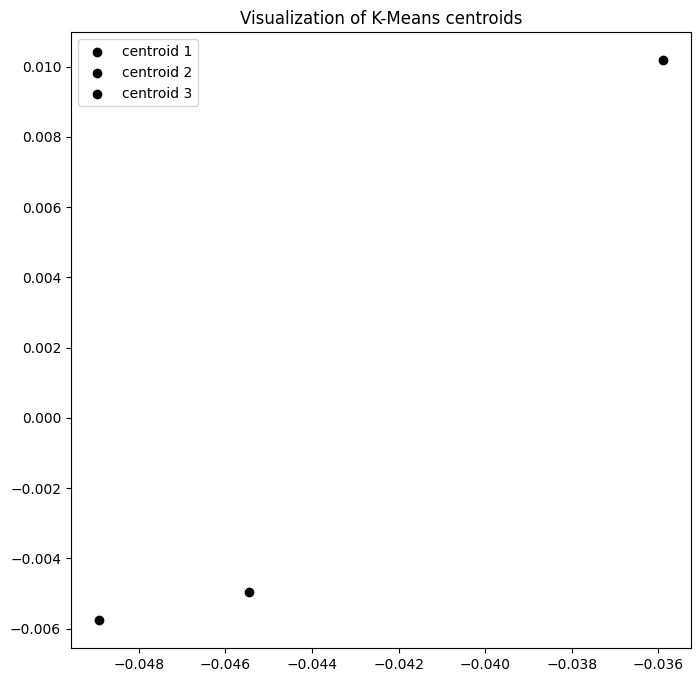

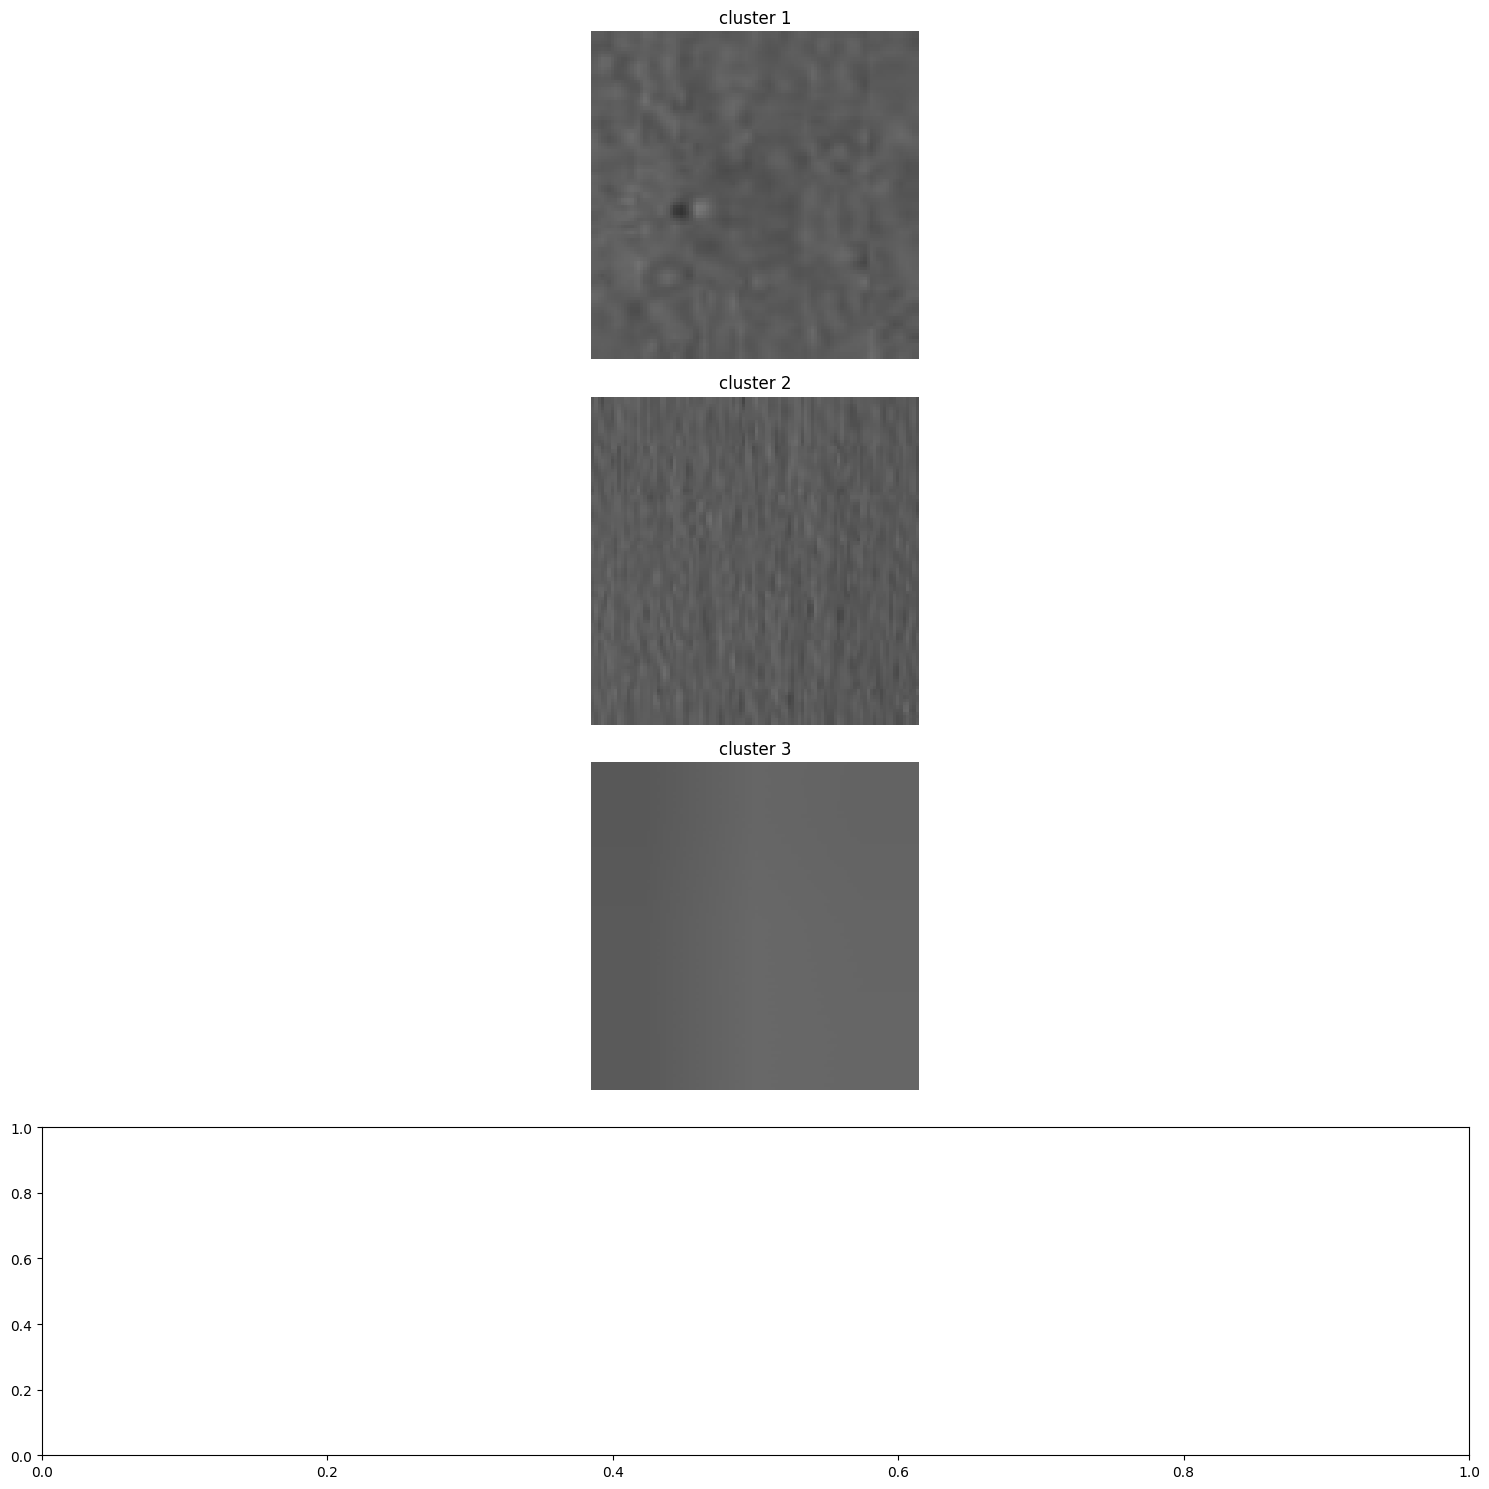

In [53]:
data_path = './cropped_defects'

images = np.array(image_read(data_path))

# Visualize the centroids of the clusters
centroids = kmeans.cluster_centers_
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(3):
    ax.scatter(centroids[i][0], centroids[i][1], c='black', label='centroid '+str(i+1))
ax.legend()
plt.title('Visualization of K-Means centroids')
plt.show()

# Визуализировать распределение изображений
fig, axes = plt.subplots(4, 1, figsize=(15, 15))
for i in range(3):
    axes[i].imshow(images[cluster_labels == i][0], cmap='gray')
    axes[i].set_title('cluster '+str(i+1))
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [54]:
def show_image_label(images, label, head=20):
    '''
    This function displays the given number of images from the 'images' array, filtered by the value of the 'label' label.
    
    Args:
      images (list): Array of images, in NumPy format.
      label (int): The label value by which the images are filtered.
      head (int, optional): Maximum number of images to display (default is 20).
    
    Returns:
      int: Returns the value of the original 'label' label.
    '''
    
    for i in range(0, len(images)):
        if head and cluster_labels[i] == label:
            display(Image.fromarray(images[i]))
            head -= 1
    
    return label

In [55]:
def image_read(data_path):
    '''
    This function reads .jpg .png images from a directory in NumPy array format.

    Args:
        data_path (str): The path to the directory with the images.

    Returns:
        list: images images array.
    '''
    
    images = []
    with tqdm.tqdm(total=len(os.listdir(data_path))) as pbar:
        for image_path in os.listdir(data_path):
            if image_path.endswith(".jpg") or image_path.endswith(".png"):
                image = cv2.imread(os.path.join(data_path, image_path))
                images.append(image)
                pbar.update(1)

    return images

In [56]:
images = image_read('./cropped_defects/')

100%|█████████▉| 8415/8416 [00:00<00:00, 9273.66it/s] 


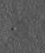

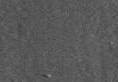

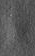

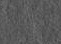

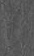

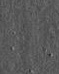

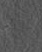

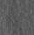

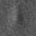

0

In [57]:
show_image_label(images, 0)

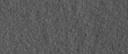

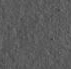

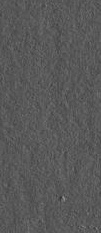

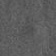

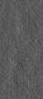

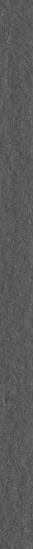

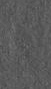

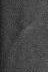

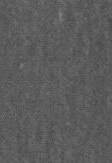

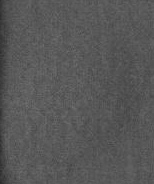

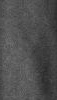

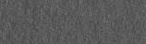

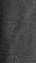

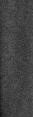

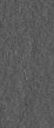

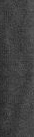

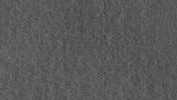

1

In [58]:
show_image_label(images, 1)

In [59]:
show_image_label(images, 2)

2

### Сохраняем данные в формате .npy для более удобной работы с ними в последующем

In [60]:
def image_read(data_path):
    '''
    This function reads .jpg .png images from a directory in NumPy array format.

    Args:
        data_path (str): The path to the directory with the images.

    Returns:
        list: images images array.
    '''
    
    images = []
    with tqdm.tqdm(total=len(os.listdir(data_path))) as pbar:
        for image_path in os.listdir(data_path):
            if image_path.endswith(".jpg") or image_path.endswith(".png"):
                image = cv2.imread(os.path.join(data_path, image_path))
                images.append(cv2.resize(image, (100, 100)))
                pbar.update(1)

    return images

In [61]:
images = image_read('./cropped_defects/')

images = np.array(images)
images.shape

100%|█████████▉| 8415/8416 [00:01<00:00, 7801.62it/s]


(8415, 100, 100, 3)

In [62]:
np.save('labels.npy', cluster_labels)

In [63]:
np.save('images.npy', images)